In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imagingIO import loopMice, loadData, loadBeh, getBeh
from analysis import dffCalc, filtData, smoothData, normData
from events import getEvents
from trials import markTrials
from bouts import getBouts, getBoutDur, markBouts
from statistics import stdCalc, getBoutMeans, getStats
from plotter import plotMean, plotHeat, plotTrials, plotHeatTrials

In [7]:
# Start gathering the data from FR1 exp
# Mice
mice = [(8404, 6), (8857, 3), (8864, 1)]
# Parameters
behType = 'FR1'
fs = 0.05
trials=[1,12]

In [8]:
# Get file paths
fileList = loopMice(mice, behType)

# Load the data
dataList = loadData(mice, behType)

# Load the behaviour
eventList = getBeh(mice, fileList['Behaviour'], behType)

In [ ]:
# Plot the raw data
"""
plt.figure(figsize=(20,10), facecolor="w", dpi= 150)
for i, [mus, sess] in enumerate(mice):
    ax = plt.subplot(len(mice),1,i+1)
    dataList[mus].plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
    ax.set_ylabel("dF/F (%)")
"""

In [ ]:
# dFF and plot
"""
dFFList = dffCalc(mice, dataList, lowest=False)

# Get the events
eventStart = getEvents(mice, eventList, 'Eat_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eat_End', trials)

# Plot the dFF data
plt.figure(figsize=(20,10), facecolor="w", dpi= 150)
for i, [mus, sess] in enumerate(mice):
    ax = plt.subplot(len(mice),1,i+1)
    dFFList[mus].plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
    ax.set_ylabel("dF/F (%)")
    
    # Plot the eating bouts
    for i, event in enumerate(eventStart[mus]):
        ax.fill_between([eventStart[mus].loc[i+1], eventEnd[mus].loc[i+1]], -10, 50, facecolor='gray', linewidth=0, alpha=0.3, zorder=-55)
"""

In [9]:
# dFF and plot again
filtList = filtData(mice, dffCalc(mice, dataList, lowest=False), cutoff=5.0, order=6)
dFFList = smoothData(mice, filtList, window=4)

# Normalize the data
normList = normData(mice, dFFList)

# Get the events
eventStart = getEvents(mice, eventList, 'Eat_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eat_End', trials)

if False:
    # Plot the dFF data
    n = 100
    fig = plt.figure(figsize=(50,50), facecolor="w", dpi= 150)
    for i, [mus, sess] in enumerate(mice):    
        offset = np.linspace(0, n, len(dFFList[mus].columns))
        ax = plt.subplot(len(mice),1,i+1)
        (dFFList[mus]+offset).plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
        ax.set_ylabel("dF/F (%)")

        # Plot the eating bouts
        for i, event in enumerate(eventStart[mus]):
            ax.fill_between([eventStart[mus].loc[i+1], eventEnd[mus].loc[i+1]], -20, 150, facecolor='gray', linewidth=0, alpha=0.3, zorder=-55)

    fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\1_all_cells_filt2_dff.svg")

In [10]:
# Look at the event PSTHs


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


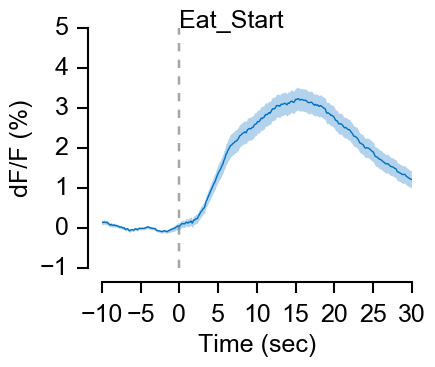

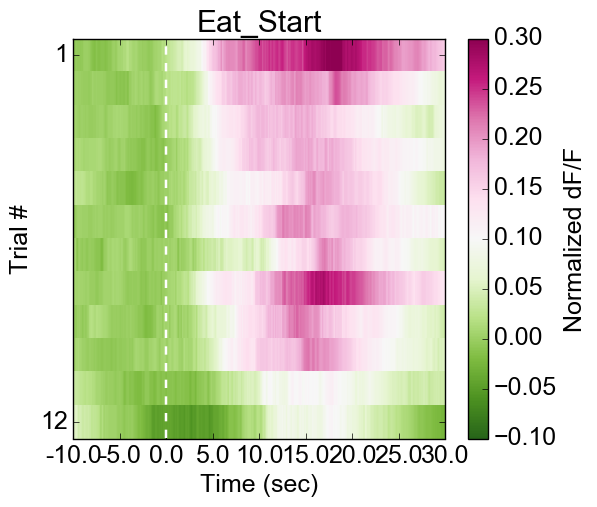

In [14]:
# Pick the event
save = False
eventType = 'Eat_Start'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if save:    
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
if save:
    fig2.savefig(fname)

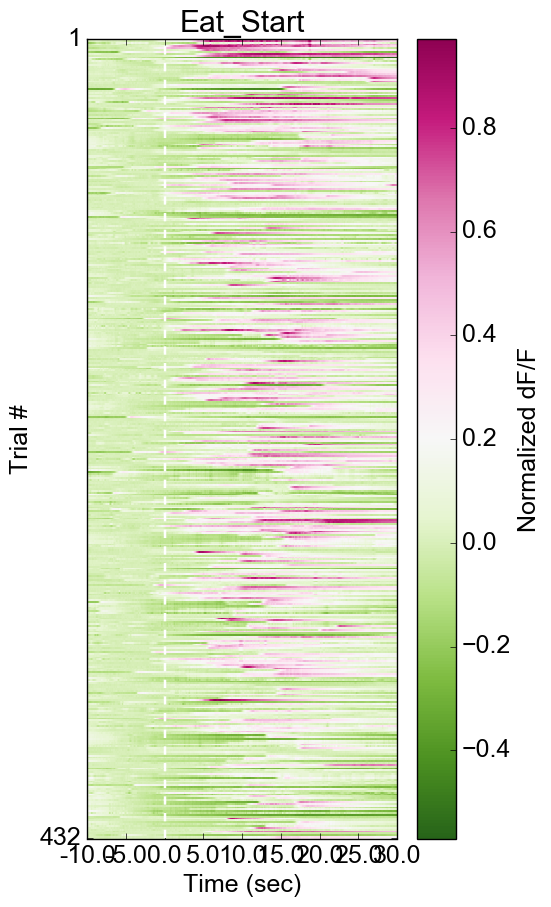

In [15]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
if save:
    fig.savefig(fname)

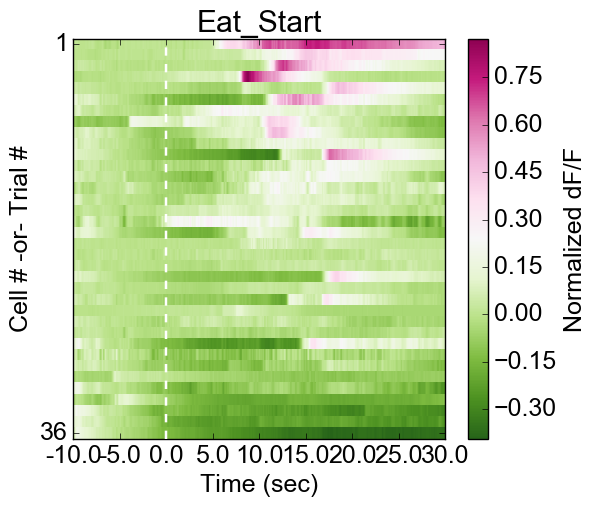

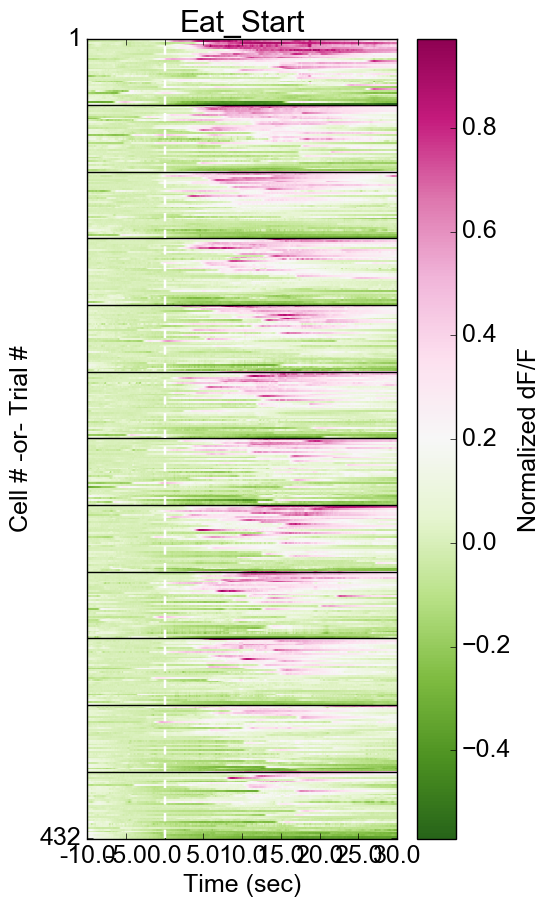

In [16]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[1]

heatTrials = pd.DataFrame()
for ind in np.arange(trials[0], trials[1]+1):
    heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[ind]

    sortAx = heatData.mean(axis=1)
    heatData
    heatData['Cell_Mean'] = sortAx
    heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

    heatTrials = heatTrials.append(heatData['Fluoro'])
    
sortAx = heatData.mean(axis=1)
heatData['Cell_Mean'] = sortAx
heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

fig, ax = plotHeatTrials(heatData['Fluoro'], eventType, base, duration, trials, fs=0.05, figsize=(6,5), seperate=False)

fig2, ax2 = plotHeatTrials(heatTrials, eventType, base, duration, trials, fs=0.05, figsize=(5,10), seperate=True)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
if save:
    fig.savefig(fname)


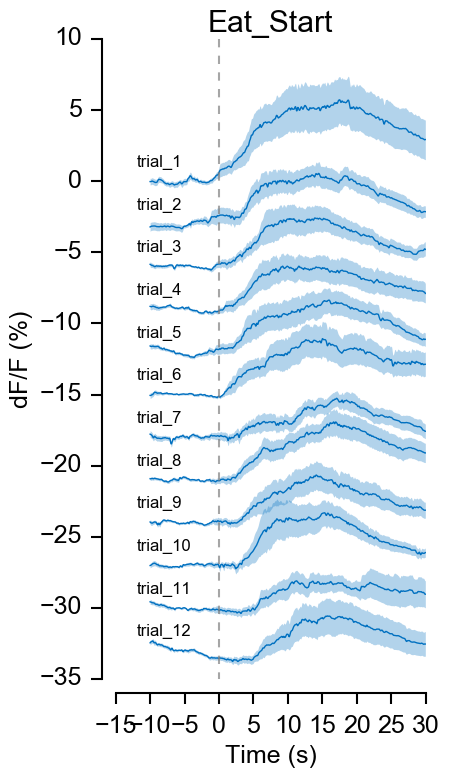

In [17]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
#eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[1]

In [ ]:
# Pick the event
eventType = 'Eat_End'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,5), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

In [ ]:
eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
# Pick the event
eventType = 'Food_Contact'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
fig2.savefig(fname)

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


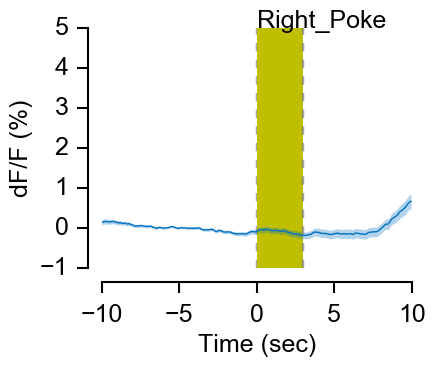

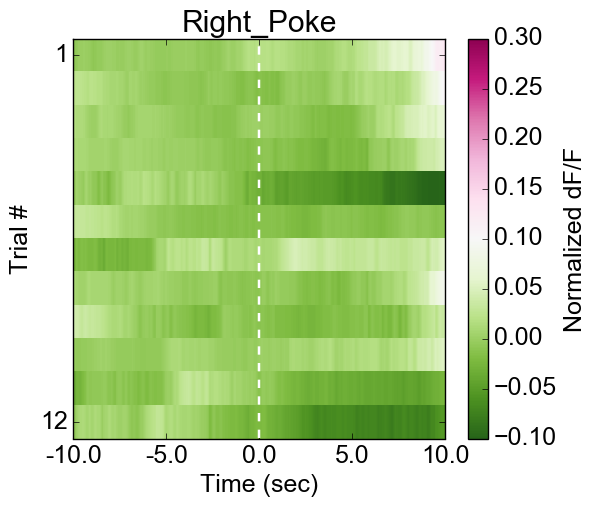

In [19]:
# Pick the event
eventType = 'Right_Poke'
base = -10.0
duration = 10.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
#fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
fig2.savefig(fname)

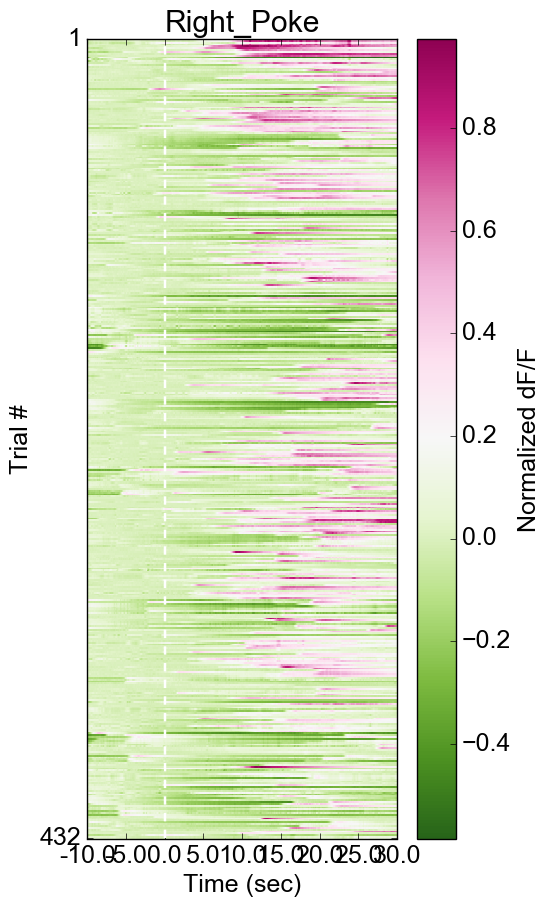

In [11]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

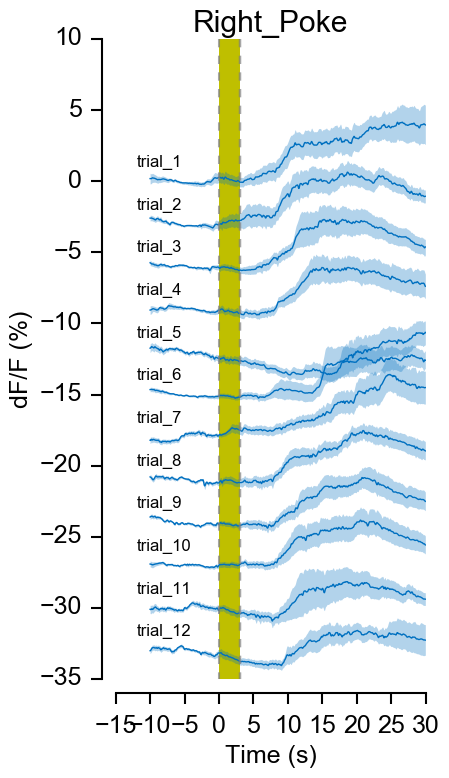

In [12]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
ax.plot([3.0, 3.0],[10, -35], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], 10, -35, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
# Pick the event
eventType = 'Left_Poke'
base = -10.0
duration = 30.0
trials = [1,2]

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)